<a href="https://colab.research.google.com/github/DazhiZhong/Pixray_Notebooks/blob/main/essence_of_pixray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# gpu check
nvidia_output = !nvidia-smi --query-gpu=memory.total --format=noheader,nounits,csv
gpu_memory = int(nvidia_output[0])
if gpu_memory < 14000:
  print(f"--> GPU check: ONLY {gpu_memory} MiB available: WARNING, some things might not work <--")
else:
  print(f"GPU check: {gpu_memory} MiB available: this should be fine")

# install
print("Installing...")
from IPython.utils import io

!rm -Rf pixray
!git clone --recursive https://github.com/samedii/pixray-1.git pixray -b blip-loss
!pip install -r pixray/requirements.txt
!pip install basicsr
!pip uninstall -y tensorflow 
!git clone https://github.com/pixray/diffvg
%cd diffvg
!git submodule update --init --recursive
!python setup.py install
%cd ..
!pip freeze | grep torch

# remind restart runtime
import os
if not os.path.isfile("first_init_complete"):
  # put stuff in here that should only happen once
  !mkdir -p models
  os.mknod("first_init_complete")
  print("Please choose Runtime -> Restart Runtime from the menu")
  print("(then continue below)")
else:
  print("Setup Complete! Good luck with your drawing")


In [1]:
#@title CLIP loss
import sys
sys.path.append("pixray")


import torch
from torch import nn
import einops
import torchvision
from torch.nn import functional as F

from Losses.LossInterface import LossInterface

try:
    from CLIP import clip
except ImportError:
    from clip import clip

# from pixray import parse_prompt, Prompt
from torchvision import transforms


class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward

    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)

replace_grad = ReplaceGrad.apply

class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))

    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()


def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    # print(f"parsed vals is {vals}")
    return vals[0], float(vals[1]), float(vals[2])


class CLIPLoss(LossInterface):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)

    
    @staticmethod
    def add_settings(parser):
        parser.add_argument("--detail_prompts", type=str, help="put in prompts to specify detail", default='', dest='detail_prompts')

        
        return parser
    


    def parse_settings(self,args):
        if args.detail_prompts:
            args.detail_prompts = [phrase.strip() for phrase in args.detail_prompts.split("|")]
        return args

    def add_globals(self,args):
        pmsTable = {}
        perceptors = {}
        
        normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                      std=[0.26862954, 0.26130258, 0.27577711])

        jit = False


        for clip_model in args.clip_models:
            perceptor = clip.load(clip_model, jit=jit, download_root="models")[0].eval().requires_grad_(False).to(self.device)
            perceptors[clip_model] = perceptor
                
        for clip_model in args.clip_models:
            pmsTable[clip_model] = []

        for prompt in args.detail_prompts:
            for clip_model in args.clip_models:
                pMs = pmsTable[clip_model]
                perceptor = perceptors[clip_model]
                txt, weight, stop = parse_prompt(prompt)
                embed = perceptor.encode_text(clip.tokenize(txt).to(self.device)).float()
                pMs.append(Prompt(embed, weight, stop).to(self.device))
        
        scale = transforms.Compose([transforms.Scale((224,224))])
        
        lossglobals = {
            'pmsTable': pmsTable,
            'perceptors': perceptors,
            'normalize':    normalize,
            'scale': scale
        }
        return lossglobals


    
    def get_loss(self, cur_cutouts, out, args, globals=None, lossGlobals=None):
        allloss = []
        d_w = 1

        for clip_model in args.clip_models:

            # #TODO
            perceptor = lossGlobals['perceptors'][clip_model]

            out = lossGlobals['scale'](out)
            iii = perceptor.encode_image( out ).float()
            pMs = lossGlobals['pmsTable'][clip_model]
            for prompt in pMs:
                allloss.append(prompt(iii)*d_w) 
        return sum(allloss)
            


In [2]:
#@title cutouts

import kornia
import kornia.augmentation as K

from typing import cast, Dict, List, Optional, Tuple, Union

global_padding_mode = 'reflection'
global_aspect_width = 1
global_spot_file = None
global_fill_color = torch.tensor((0.0,0.0,0.0))



# override class to get padding_mode
class MyRandomPerspective(K.RandomPerspective):
    def apply_transform(
        self, input: torch.Tensor, params: Dict[str, torch.Tensor], transform: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        _, _, height, width = input.shape
        transform = cast(torch.Tensor, transform)
        return kornia.geometry.transform.warp_perspective(
            input, transform, (height, width), mode=self.flags["resample"].name.lower(),
            align_corners=self.flags["align_corners"], padding_mode=global_padding_mode
        )


# override class to get fill color
class MyRandomAffine(K.RandomAffine):
    def apply_transform(
        self, input: torch.Tensor, params: Dict[str, torch.Tensor], transform: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        _, _, height, width = input.shape
        transform = cast(torch.Tensor, transform)
        return kornia.geometry.transform.warp_affine(
            input,
            transform[:, :2, :],
            (height, width),
            self.flags["resample"].name.lower(),
            align_corners=self.flags["align_corners"],
            padding_mode="fill",
            fill_value=global_fill_color
        )

class MyRandomPerspectivePadded(K.RandomPerspective):
    def apply_transform(
        self, input: torch.Tensor, params: Dict[str, torch.Tensor], transform: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        _, _, height, width = input.shape
        transform = cast(torch.Tensor, transform)
        return kornia.geometry.transform.warp_perspective(
            input, transform, (height, width), mode=self.flags["resample"].name.lower(),
            align_corners=self.flags["align_corners"],
            padding_mode="fill",
            fill_value=global_fill_color
        )




class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        global global_aspect_width

        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cutn_zoom = int(0.6*cutn)
        self.cut_pow = cut_pow
        self.transforms = None

        augmentations = []
        # if global_aspect_width != 1:
        #     augmentations.append(K.RandomCrop(size=(self.cut_size,self.cut_size), p=1.0, cropping_mode="resample", return_transform=True))
        augmentations.append(MyRandomPerspective(distortion_scale=0.40, p=0.7, return_transform=True))
        augmentations.append(K.RandomResizedCrop(size=(self.cut_size,self.cut_size), scale=(0.25,0.95),  ratio=(0.85,1.2), cropping_mode='resample', p=1.0, return_transform=True))
        augmentations.append(K.ColorJitter(hue=0.1, saturation=0.1, p=0.8, return_transform=True))
        self.augs_zoom = nn.Sequential(*augmentations)

        augmentations = []
        if global_aspect_width == 1:
            n_s = 0.95
            n_t = (1-n_s)/2
            augmentations.append(MyRandomAffine(degrees=0, translate=(n_t, n_t), scale=(n_s, n_s), p=1.0, return_transform=True))
        elif global_aspect_width > 1:
            n_s = 1/global_aspect_width
            n_t = (1-n_s)/2
            augmentations.append(MyRandomAffine(degrees=0, translate=(0, n_t), scale=(0.9*n_s, n_s), p=1.0, return_transform=True))
        else:
            n_s = global_aspect_width
            n_t = (1-n_s)/2
            augmentations.append(MyRandomAffine(degrees=0, translate=(n_t, 0), scale=(0.9*n_s, n_s), p=1.0, return_transform=True))

        # augmentations.append(K.CenterCrop(size=(self.cut_size,self.cut_size), p=1.0, cropping_mode="resample", return_transform=True))
        augmentations.append(K.CenterCrop(size=self.cut_size, cropping_mode='resample', p=1.0, return_transform=True))
        augmentations.append(MyRandomPerspectivePadded(distortion_scale=0.20, p=0.7, return_transform=True))
        augmentations.append(K.ColorJitter(hue=0.1, saturation=0.1, p=0.8, return_transform=True))
        self.augs_wide = nn.Sequential(*augmentations)

        self.noise_fac = 0.1
        
        # Pooling
        self.av_pool = nn.AdaptiveAvgPool2d((self.cut_size, self.cut_size))
        self.max_pool = nn.AdaptiveMaxPool2d((self.cut_size, self.cut_size))

    def forward(self, input, spot=None):
        global global_aspect_width, cur_iteration
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        mask_indexes = None

        if spot is not None:
            spot_indexes = fetch_spot_indexes(self.cut_size, self.cut_size)
            if spot == 0:
                mask_indexes = spot_indexes[1]
            else:
                mask_indexes = spot_indexes[0]
            # print("Mask indexes ", mask_indexes)

        for _ in range(self.cutn):
            # Pooling
            cutout = (self.av_pool(input) + self.max_pool(input))/2

            if mask_indexes is not None:
                cutout[0][mask_indexes] = 0.0 # 0.5

            if global_aspect_width != 1:
                if global_aspect_width > 1:
                    cutout = kornia.geometry.transform.rescale(cutout, (1, global_aspect_width))
                else:
                    cutout = kornia.geometry.transform.rescale(cutout, (1/global_aspect_width, 1))

            # if cur_iteration % 50 == 0 and _ == 0:
            #     print(cutout.shape)
            #     TF.to_pil_image(cutout[0].cpu()).save(f"cutout_im_{cur_iteration:02d}_{spot}.png")

            cutouts.append(cutout)

        if self.transforms is not None:
            # print("Cached transforms available")
            batch1 = kornia.geometry.transform.warp_perspective(torch.cat(cutouts[:self.cutn_zoom], dim=0), self.transforms[:self.cutn_zoom],
                (self.cut_size, self.cut_size), padding_mode=global_padding_mode)
            batch2 = kornia.geometry.transform.warp_perspective(torch.cat(cutouts[self.cutn_zoom:], dim=0), self.transforms[self.cutn_zoom:],
                (self.cut_size, self.cut_size), padding_mode="fill", fill_value=global_fill_color)
            batch = torch.cat([batch1, batch2])
            # if cur_iteration < 2:
            #     for j in range(4):
            #         TF.to_pil_image(batch[j].cpu()).save(f"cached_im_{cur_iteration:02d}_{j:02d}_{spot}.png")
            #         j_wide = j + self.cutn_zoom
            #         TF.to_pil_image(batch[j_wide].cpu()).save(f"cached_im_{cur_iteration:02d}_{j_wide:02d}_{spot}.png")
        else:
            batch1, transforms1 = self.augs_zoom(torch.cat(cutouts[:self.cutn_zoom], dim=0))
            batch2, transforms2 = self.augs_wide(torch.cat(cutouts[self.cutn_zoom:], dim=0))
            # print(batch1.shape, batch2.shape)
            batch = torch.cat([batch1, batch2])
            # print(batch.shape)
            self.transforms = torch.cat([transforms1, transforms2])
            ## batch, self.transforms = self.augs(torch.cat(cutouts, dim=0))
            # if cur_iteration < 4:
            #     for j in range(4):
            #         TF.to_pil_image(batch[j].cpu()).save(f"live_im_{cur_iteration:02d}_{j:02d}_{spot}.png")
            #         j_wide = j + self.cutn_zoom
            #         TF.to_pil_image(batch[j_wide].cpu()).save(f"live_im_{cur_iteration:02d}_{j_wide:02d}_{spot}.png")

        # print(batch.shape, self.transforms.shape)
        
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch



reusing cached copy of model  models/vqgan_imagenet_f16_16384.ckpt


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


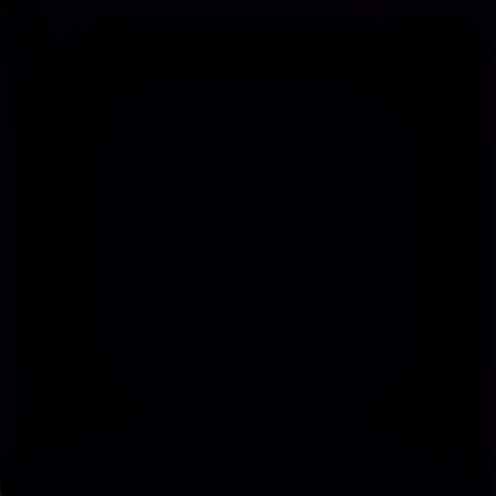

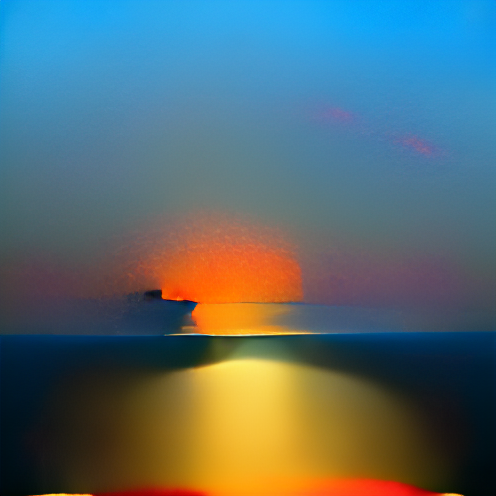

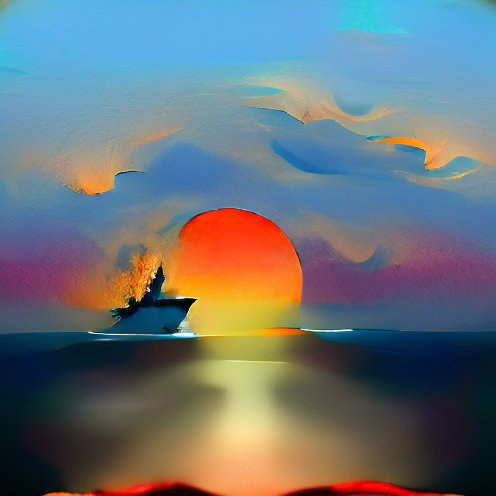

In [7]:

import sys
sys.path.append("pixray")
import torch
from torch import nn, optim
from types import SimpleNamespace
from torchvision.utils import save_image
from IPython import display

from vqgan import VqganDrawer
from Losses.EdgeLoss import EdgeLoss

#drawer
d = VqganDrawer(SimpleNamespace(vqgan_model="imagenet_f16_16384"))
d.load_model(SimpleNamespace(vqgan_model="imagenet_f16_16384",vqgan_config=None, vqgan_checkpoint=None),device="cuda:0")
# d.init_from_tensor(torch.rand([1,3,224,224]).mul(2).sub(1).to("cuda:0"))
d.init_from_tensor(torch.zeros([1,3,500,500]).mul(2).sub(1).to("cuda:0"))

#loss
el = EdgeLoss(device="cuda:0")
args = SimpleNamespace(edge_color="white",
          edge_thickness=10,
          edge_margins=(10, 10, 10, 10),
          edge_input_image=None,
          edge_mask_image=None,
          global_color_weight=0.01,
          edge_color_weight=0.00,
          )
args = el.parse_settings(args)

lossGlobals = {}

arg = SimpleNamespace(detail_prompts="a sunset at sea",clip_models=["ViT-B/16","ViT-B/32"] )
d2 = CLIPLoss(device="cuda:0")
d2.parse_settings(arg)
lossGlobals.update(d2.add_globals(arg))

#cutout
cut = MakeCutouts(224,40)

#opt
opt = optim.Adam([d.get_z()],lr=0.3)
for i in range(100):
    out = d.synth(None)
    loss= [
        el.get_loss(None, out, args),
        d2.get_loss(None, cut(out), arg, globals=None, lossGlobals=lossGlobals)
    ]
    loss = sum(loss)
    loss.backward()
    opt.step()
    opt.zero_grad()
    if i%50==0:
        save_image(out,"name.png")
        display.display(display.Image("name.png"))

#show
save_image(out,"name.png")
display.display(display.Image("name.png"))